In [ ]:
"""
YOLO(You Only Look Once) : 객체 탐지 딥러닝 알고리즘 및 모델
- 이미지를 여러 단계로 분리하지 않고, 하나의 신경망(Convolutional Neural Network)이 세 가지 핵심 작업을 동시에 수행
- 다중 신경망 모델(R-CNN 등)에 비해 속도가 매우 빨라 실시간 처리가 가능하다.

1. 이미지 분할 (Grid Division)
- 입력된 이미지를 S * S 크기의 작은 그리드 셀로 나눕니다
- 객체의 중심점이 포함된 셀이 그 객체의 탐지를 책임집니다

2. 동시 예측 (Simultaneous Prediction) : 신경망은 각 그리드 셀에 대해 다음 세 가지 정보를 한 번의 실행으로 동시에 예측합니다.
- 바운딩 박스 (Bounding Box): 객체의 위치와 크기.
- 신뢰도 점수 (Confidence Score): 객체가 존재할 확률과 예측 정확도.
- 클래스 확률 (Class Probability): 해당 객체가 무엇인지 (예: 사람, 스마트폰 등)의 확률.

3. 최종 필터링 (NMS - Non-Maximum Suppression)
- 하나의 객체 주변에 여러 개의 중복된 바운딩 박스가 예측되므로, NMS 과정을 통해 가장 높은 신뢰도 점수를 가진 박스만 남기고 나머지 중복된 박스는 제거합니다.
"""

객체 감지

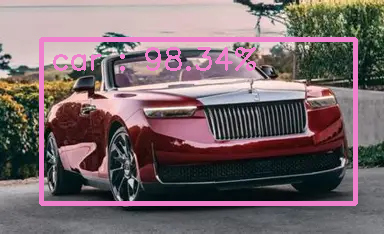

In [ ]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import requests
import random

weights_path = "yolo3/yolov3.weights"   # YOLOv3 모델의 가중치(weights) 파일
config_path = "yolo3/yolov3.cfg"        # YOLOv3 모델의 구성(configuration) 파일
names_path = "yolo3/coco.names"         # 모델이 탐지할 수 있는 객체 이름(클래스 이름) 목록이 포함된 파일

with open(names_path, 'r', encoding='utf-8') as coco_file : 
    label_list = coco_file.read().strip().split('\n')

# weights_path와 config_path에 지정된 파일을 기반으로 딥러닝 신경망 모델(YOLOv3)을 메모리에 로드
net = cv2.dnn.readNet(weights_path, config_path)

def random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 

def detect_objects(image_arr) : 
    image_arr = image_arr.copy()
    
    image_height, image_width = image_arr.shape[:2]

    # 모든 픽셀 값(0~255)을 255로 나누어 정규화 처리. 즉, 각 픽셀 값이 0~1 사이의 값으로 변경됨
    # (416,416) : 출력 블롭의 공간 크기. 특정 YOLO 모델(예: 416x416)의 요구 사항에 맞춰야 함.
    # swapRB=True : BRG => RGB. OpenCV는 기본적으로 BGR 순서로 이미지를 로드하지만, YOLO와 같은 딥러닝 모델은 일반적으로 RGB 형태로 훈련되었음.
    # crop=False : 이미지 크롭(자르기)을 수행할지 여부.
    blob = cv2.dnn.blobFromImage(image_arr, 1/255.0, (416, 416), swapRB=True, crop=False)

    # 416 * 416 = 173,056 이지만, 아래 blob의 size는 519,168임.
    # 416 * 416은 1개 채널(R or G or B)이며, 총 3개의 채널이 존재하니 416 * 416 * 3 = 519,168
    #print(blob.size)

    # 전처리된 이미지 데이터를, YOLO 모델의 첫번 째 계층으로 전달.
    net.setInput(blob)

    # YOLO는 서로 다른 크기의 객체를 탐지하기 위해, 출력 레이어가 3개임. 해당 출력 레이어들의 이름을 리스트로 가져옴.
    # 'yolo_82', 'yolo_94', 'yolo_106'
    out_layer_list = net.getUnconnectedOutLayersNames()

    # 전처리된 이미지를 순방향(입력=>출력)으로 추론(실행함)함. 이 때 인자로 전달한 out_layer_list의 모든 출력 레이어에 맞는 결과를 계산 후 반환
    # len(detection_list)이 3인 이유가, 인자로 전달한 out_layer_list가 3개이기 때문.
    detection_list = net.forward(out_layer_list)

    bounding_box_list = []
    confidence_list = []
    label_index_list = []

    for prediction_list in detection_list : # 'yolo_82', 'yolo_94', 'yolo_106'
        for prediction in prediction_list :
            # 각 prediction의 0~3번 요소는 중심 x,y 좌표 및 크기, 4번 요소는 점수(불필요값), 5~84번 요소는 각 label에 해당할 확률값.
            label_score_list = prediction[5:]           # coco.names의 모든 라벨에 대한 확률값. coco.names의 라벨 갯수가 80이므로, 이 리스트 또한 len이 80임.
            label_index = np.argmax(label_score_list)   # 각 label별 확률 중, 가장 높은 확률값의 인덱스를 반환
            confidence = label_score_list[label_index]  # 각 label별 확률 중, 가장 높은 확률값
                    
            # 정확도가 0보다 큰 결과만을 가지고 후처리 하기위해 리스트에 append
            if confidence > 0 : 
                # 각 좌표값은 width, height에 대한 비율 값이므로, width와 height를 곱해주므로서 위치 좌표를 찾아낸다.
                # ex) 이미지 width가 1000px인데, 구해진 bbox의 width 값이 0.10%라면 bbox는 100px
                bounding_box = prediction[:4] * np.array([image_width, image_height, image_width, image_height])
                center_x, center_y, w, h = bounding_box.astype('int') # 소수점 제외

                # YOLO는 x,y가 bbox의 좌상단이 아닌, 중심 좌표 값을 가짐. 
                # center_x는 이미지 너비에 대한, bbox x좌표의 중심. 이미지 너비가 600일 때, center_x가 0.5라면 bbox x좌표의 '중심값'의 위치는 이미지 좌측에서 300px 떨어진 곳.
                # 위에 코드에서 center_x에 이미지 넓이를 곱했으니, 현재 center_x는 300임(600 *0.5).
                # bbox의 w가 50px이라면 x = 300px - (50px / 2) = 275px. 즉, bbox의 x좌표 시작점은 275px이고, 끝점은 325px
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                #print(f"예측 개체 : {label_list[label_index]}, 인덱스 : {label_index}, 확률 : {confidence}")
                #cv2.rectangle(image_arr, (x,y), (x+w, y+h), color, 3)
                bounding_box_list.append([x,y,w,h])
                confidence_list.append(confidence)
                label_index_list.append(label_index)

    # 이미지에서 감지된 bbox들 중, 신뢰도가 0.1 이상이고, 겹침의 정도가 0.5 이상인 bbox의 인덱스들만 반환
    extracted_index_list = cv2.dnn.NMSBoxes(bounding_box_list, confidence_list, 0.5, 0.1)

    for extract_index in extracted_index_list :
        color = random_color()

        x, y, w, h = bounding_box_list[extract_index]
        confidence = confidence_list[extract_index]
        label_index = label_index_list[extract_index]
        label_text = label_list[label_index]

        cv2.rectangle(image_arr, (x,y), (x+w, y+h), color, 3)
        cv2.putText(image_arr, f"{label_text} : {(confidence*100):.2f}%", (x+10,y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness=2)

    return image_arr


Open AI 

In [83]:
import io
import base64
from dotenv import load_dotenv
import os
from PIL import Image, ImageDraw, ImageFont
load_dotenv()

def request_gpt(image_arr) :
    # 이미지 배열 => PIL 형태 이미지로
    image = Image.fromarray(image_arr)

    # byte 형태 이미지를 저장할 변수
    byte_image = io.BytesIO()

    # PIL 이미지 => byte형태로 변환하여, byte_image에 저장
    image.save(byte_image, format='png')

    # byte 형태 이미지 => base64 형태로 변환 (GPT에 전송할 형식)
    base64_image = base64.b64encode(byte_image.getvalue()).decode('utf-8')


    endpoint = "https://8ai022-openai.openai.azure.com/openai/deployments/gpt-4o-mini/chat/completions?api-version=2025-01-01-preview"

    headers = {
        'api-key' : os.getenv("AZURE_OAI_KEY"),
        'Content-Type' : 'application/json'
    }

    body = {
        "messages": [
            {
                "role": "system",
                "content": [
                    {
                        "type": "text",
                        "text": """
                        당신은 YOLO 객체 감지 모델의 분석 결과를 전문적으로 해설하는 AI 분석가입니다.
                        제공된 이미지와 함께 전달된 객체 감지 결과(감지 확률, 객체 종류, 위치 등)를 기반으로 하여, 각 감지된 물체에 대해 가장 상세하고 정확하게 설명해야 합니다.
                        모든 응답은 한국어로 작성해야 합니다.
                        """
                    }
                ]
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": """
                        첨부된 사진은 YOLO 모델을 통해 분석되었으며, 해당 모델이 감지한 **모든 물체**에 대한 정보를 바탕으로 상세 분석 보고서를 작성해 주세요.

                        **[요청 사항]**
                        1.  **감지된 물체 목록**을 '객체 종류', '감지 확률', '이미지 내 위치(바운딩 박스 좌표/대략적 위치)'를 요약해 주세요.
                        2.  **각 물체별로** 다음 내용을 포함하여 **자세한 설명**을 항목별로 추가해 주세요.
                            * 물체의 특징 (색상, 상태, 용도 등)
                            * 물체의 예상되는 역할 또는 주변 환경과의 관계
                        3.  **감지되지 않은 영역이나 배경에 대한 설명은 일체 포함하지 마세요.**
                        """
                    },
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                    }
                ]
            }
        ],
        "temperature": 0.7,
        "top_p": 0.95,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "max_tokens": 16384,
        "stop": None,
        "stream": False
    }

    response = requests.post(endpoint, headers=headers, json=body)
    
    if response.status_code != 200 :
        print(f"Http Request Error ! {response.status_code}")
        return None
    
    response_json = response.json()
    result_text = response_json['choices'][0]['message']['content']
    return result_text

#response = requests.get("https://th.bing.com/th/id/OIP.vzDjqYSlt8Cf_L_IW9RFdgHaEA?w=296&h=180&c=7&r=0&o=7&cb=ucfimg2&dpr=1.3&pid=1.7&rm=3&ucfimg=1")
#image_data = response.content                       # 바이트 형태로 읽음
#image_np = np.frombuffer(image_data, np.uint8)      # numpy 형태의 1차원 배열로 변환
#image_arr = cv2.imdecode(image_np, cv2.IMREAD_COLOR)    # cv2에서 사용할 수 있도록 2차원/3차원 형태 배열로 디코딩
#request_gpt(image_arr)

Speech TTS

In [97]:
import re

def request_tts(text) : 
    # 1. Endpoint
    endpoint = "https://eastus.tts.speech.microsoft.com/cognitiveservices/v1"

    # 2. Header
    headers = {
        "Content-Type" : "application/ssml+xml",
        "Ocp-Apim-Subscription-Key" : os.getenv("STT_OCP_APIM_SUB_KEY"),
        "X-Microsoft-OutputFormat" : "audio-16khz-128kbitrate-mono-mp3"
    }

    # 나열된 문자(한글, 영문자)를 제외한 문자 제외
    text = re.sub(r'[^가-힣a-zA-Z0-9\s%,\.]', '', text)
    
    # 3. Body : SSML
    body = f"""
    <speak version='1.0' xml:lang='ko-KR'>
        <voice name="ko-KR-SoonBokNeural" style="customerservice" rate="1.2">
            {text}
        </voice>
    </speak>
    """

    # request Audio => Text
    response = requests.post(endpoint, headers=headers, data=body)

    if response.status_code != 200 :
        print(f"Http Request Error {response.status_code}")
        return None
    
    
    # Hex => mp3 파일로 변환
    import datetime
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file_path = f"files/tts_{now}_output.mp3"
    with open(output_file_path, "wb") as output_audio :
        output_audio.write(response.content)
    
    return output_file_path


Gradio 화면

In [ ]:
import gradio as gr
import datetime

with gr.Blocks() as demo : 

    def stream_webcam(image_arr) :
        result_image_array = detect_objects(image_arr)
        return result_image_array
    def capture(output_image) :
        if output_image is None : 
            return gr.Error("감지된 이미지가 없습니다.", duration=3)
        return output_image
    def analysis(capture_image, histories) :
        # 캡처된 이미지 분석 요청
        gpt_result_text = request_gpt(capture_image)
        
        # Chatbot 컴포넌트가 이해하는 형태로 리턴
        label_text = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        histories.append(
            {"role" : "user", "content" : gr.Image(label=label_text, value=capture_image)}
        )
        histories.append(
            {"role" : "assistant", "content" : gpt_result_text}
        )
        return histories
    
    def change_chatbot(histories) :
        content = histories[-1]["content"][0]["text"]
        tts_file_path = request_tts(content)
        return tts_file_path
    
    with gr.Row() : 
        # 웹 캠에서 실시간으로 이미지를 가져옴 
        webcam_image = gr.Image(label="실시간 화면", sources="webcam")
        output_image = gr.Image(label="감지 화면")
        capture_image = gr.Image(label="이상 징후 감지 화면", interactive=False)
    with gr.Row() :
        capture_buttom = gr.Button("이상 징후 감지")
        analysis_buttom = gr.Button("분석")

    analysis_text = gr.Chatbot(label="분석 결과", value=[])
    analysis_audio = gr.Audio(label="분석 결과", interactive=False, autoplay=True)

    webcam_image.stream(fn=stream_webcam, inputs=[webcam_image], outputs=[output_image])
    capture_buttom.click(fn=capture, inputs=[output_image], outputs=[capture_image])

    # 분석할때마다 히스토리가 누적되어야 하므로, input에 analysis_text가 들어감.
    analysis_buttom.click(fn=analysis, inputs=[capture_image, analysis_text], outputs=[analysis_text])

    # 분석 결과 갱신시마다, 결과 텍스트 Audio
    analysis_text.change(change_chatbot, inputs=[analysis_text], outputs=[analysis_audio])

demo.launch()
        

* Running on local URL:  http://127.0.0.1:7878
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\EL32\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\queueing.py", line 763, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\EL32\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\EL32\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 2106, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\EL32\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\blocks.py", line 1588, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\EL32\AppData\Local\Progra